# Title: Santa Barbara Thomas Fire Air Quality Index (AQI) Analysis
Author: Carly Caswell

Repository: https://github.com/ccaswell25/eds220-hwk4-task3 

## About

### Purpose
I will create a false color image to show the location of the Thomas fire in 2017 and the impact of air quality on that specific area during the time period of the fire.  

### Highlights

-Geospatial data exploration 

-Data wrangling and manipulation  

-Daya analysis calculate moving averages for air quality index during the period of the Thomas Fire

-Creating and customizing a map of the Thomas fire area and AQI moving averages

### Dataset Description and References

**Dataset 1**

A simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite. 

Information about Landsat bands from USGS:

[What are the band designations for the Landsat satellites?](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites)

[Common Landsat Band Combinations](https://www.usgs.gov/media/images/common-landsat-band-combinations)

[How do I use a scale factor with Landsat Level-2 science products?](https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products)


The data was accessed and pre-processed in the Microsoft Planetary Computer to remove data outside land and coarsen the spatial resolution ([Landsat Collection in MPC](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)). Data should be used for visualization purposes only. 


**Dataset 2**

A shapefile of fire perimeters in California during 2017. 
The [complete file can be accessed in the CA state geoportal](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about).

 
**Dataset 3**

We are using [Air Quality Index (AQI)](https://www.airnow.gov/aqi/aqi-basics/) data from the [US Environmental Protection Agency](https://www.epa.gov) to visualize the impact on the AQI of the 2017 [Thomas Fire](https://en.wikipedia.org/wiki/Thomas_Fire) in Santa Barbara County. 

# Importing 

In [79]:
#Importing Libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rioxr
import xarray as xr
import pandas as pd 
from shapely.geometry import Polygon 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from shapely.geometry import Point
import matplotlib.lines as mlines


In [67]:
# Importing Data
#Reading in bands data 
bands = os.path.join(os.getcwd(), 'data', 'landsat8-2018-01-26-sb-simplified.nc') 
bands = rioxr.open_rasterio(bands)

#Reading in CA fires data 
ca_fires = gpd.read_file(os.path.join(os.getcwd(), 'data', 'California_Fire_Perimeters_2017.shp'))

#Reading in AQI data for 2017 and 2018
aqi_17 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip")
aqi_18 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip")


# Data Exploration

Let's take a look at the data we have for AQI, California fires, and Landsat now that we have read it in.

In [68]:
#AQI DATA
#Taking an initial look at my 2017 dataframe:
print(aqi_17.head())
#Taking an initial look at my 2018 dataframe:
print(aqi_18.head())
#Additional data exploration to view the columns of the dataframe:
print(aqi_17.columns)
print(aqi_18.columns)


#CALIFORNIA FIRES DATA 
#Checking the columns of the CA fires data
ca_fires.columns
# I see that there are differences in the formats, so I will change them to lowercase later on


#LANDSAT COLLECTION 2 DATA 
print('height:', bands.rio.height)
print('width:', bands.rio.width)
print('resolution:', bands.rio.resolution())
print('dims:', bands.dims)
#I can see that there is an extra band so I am going to remove it as part of my analysis

  State Name county Name  State Code  County Code        Date  AQI Category  \
0    Alabama     Baldwin           1            3  2017-01-01   21     Good   
1    Alabama     Baldwin           1            3  2017-01-04   22     Good   
2    Alabama     Baldwin           1            3  2017-01-10   19     Good   
3    Alabama     Baldwin           1            3  2017-01-13   30     Good   
4    Alabama     Baldwin           1            3  2017-01-16   16     Good   

  Defining Parameter Defining Site  Number of Sites Reporting  
0              PM2.5   01-003-0010                          1  
1              PM2.5   01-003-0010                          1  
2              PM2.5   01-003-0010                          1  
3              PM2.5   01-003-0010                          1  
4              PM2.5   01-003-0010                          1  
  State Name county Name  State Code  County Code        Date  AQI Category  \
0    Alabama     Baldwin           1            3  2018-01-02 

# Data Wrangling
Let's update the datasets and clean anything that may need updated and wrangle the data to be more aligned with what we're hoping to analyze. 

1. We want to simplify the columns in the datasets and make sure we do not have any extra dimensions in our bands dataframe. 

2. Then, we want to combine our aqi_17 and aqi_18 dataframes into one and wrangle the data so we only have the location and columns we care about.  

3. We then want to narrow our data focus and update it to specifically look at the Thomas Fire and Santa Barbara county. 

4. Lastly, we need to make sure our mapping data is in the same CRS so we can project it on the same scale.

In [69]:
1. ## Making the CA Fires columns lowercase 
ca_fires.columns = ca_fires.columns.str.lower()
ca_fires.head() #checking the columns were updated

## Removing the band from the bands dataframe:
bands = bands.squeeze()
bands = bands.drop('band')
print(bands.dims, '\n', bands.coords, '\n') #checking the band was removed from our dataframe


Frozen({'y': 731, 'x': 870}) 
 Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
    spatial_ref  int64 0 



In [70]:
2. #Updating AQI Data:
# Combining the dataframes into one
aqi = pd.concat([aqi_17, aqi_18])

# We also want to reset the index
aqi = aqi.reset_index(drop=True)
print(aqi.index) #yes we can confirm this looks right

# Checking the columns:
print(aqi.columns, '\n')
#We want to make them lowercase now:
aqi.columns = aqi.columns.str.lower()
print(aqi.columns, '\n')
#We still see that there are spaces in the names, so lets replace with a '_'
aqi.columns = aqi.columns.str.replace(' ','_')
print(aqi.columns) 
#Nice, the columns look good! 


RangeIndex(start=0, stop=654338, step=1)
Index(['State Name', 'county Name', 'State Code', 'County Code', 'Date', 'AQI',
       'Category', 'Defining Parameter', 'Defining Site',
       'Number of Sites Reporting'],
      dtype='object') 

Index(['state name', 'county name', 'state code', 'county code', 'date', 'aqi',
       'category', 'defining parameter', 'defining site',
       'number of sites reporting'],
      dtype='object') 

Index(['state_name', 'county_name', 'state_code', 'county_code', 'date', 'aqi',
       'category', 'defining_parameter', 'defining_site',
       'number_of_sites_reporting'],
      dtype='object')


In [71]:
#3. Looking at just the Thomas Fire and Santa Barbara county. 

#AQI DATA
# Selecting data from 'Santa Barbara' county
aqi_sb = aqi[aqi['county_name'] == 'Santa Barbara'].copy()

# Dropping specified columns
columns_to_drop = ['state_name', 'county_name', 'state_code', 'county_code']
aqi_sb.drop(columns_to_drop, inplace=True, axis = 1)

# Checking data types of the columns
print(aqi_sb.dtypes)
#The data column is stored as an object and it needs to be converted to datetime!

# Updating the date column to a datetime object
aqi_sb['date'] = pd.to_datetime(aqi_sb['date'])

# Setting the index to be the date column
aqi_sb.set_index('date', inplace=True)

# Checking the updated DataFrame
print(aqi_sb.index)
#the data type is datetime, which looks correct! 


# CA FIRES DATA
# Making sure I have just the Thomas Fire data:
ca_fires_new = ca_fires[ca_fires.fire_name == "THOMAS"]


date                         object
aqi                           int64
category                     object
defining_parameter           object
defining_site                object
number_of_sites_reporting     int64
dtype: object
DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=730, freq=None)


In [72]:
# 4. Updating the CRS's:
print(ca_fires.crs)
print(bands.rio.crs)
#I noticed they are different so I'm going to convert the CA crs
ca_fires_new = ca_fires_new.to_crs(32611)

#checking to make sure the crs is updated:
ca_fires_new.crs == bands.rio.crs

epsg:3857
EPSG:32611


True

# Data Analysis

## Rolling Averages 

In [73]:
#Calculating rolling window for the AQI_SB data:
aqi_sb.aqi.rolling('5D').mean()

# Adding a new column with the 5-day rolling mean:
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean()

#Now we can plot the rolling averages! 

## Creating a False Image of CA Thomas Fire 

In [77]:
#Creating a false color image 
bands[["swir22", "nir08", "red"]].to_array()
#Now we have our image we can graph this with our Thomas Fire perimeter

<xarray.DataArray (variable: 3, y: 731, x: 870)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
    spatial_ref  int64 0
  * variable     (variable) <U6 'swir22' 'nir08' 'red'

# Final Output

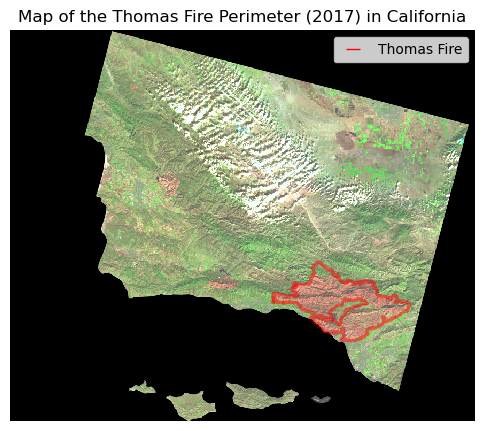

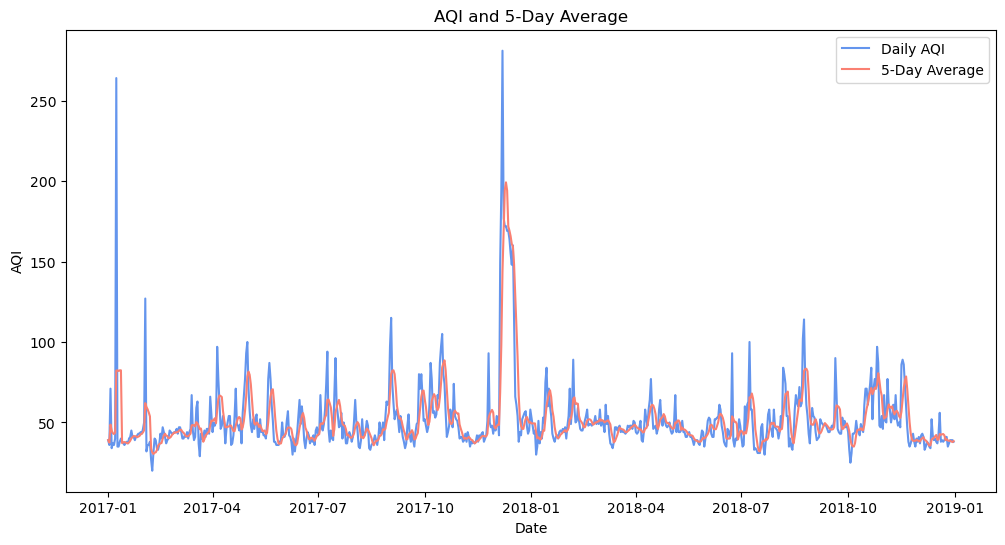

In [80]:
## Plotting the shapefile
fig, ax = plt.subplots()
size = 6 #height in of plot 
aspect = bands.rio.width/bands.rio.height
fig.set_size_inches(size, size*aspect) #why? bc cannot use ax and size aspect together
bands[["swir22", "nir08", "red"]].to_array().plot.imshow(ax=ax, robust = True)
ca_fires_new .plot(ax=ax,facecolor='none', edgecolor='red', linewidth=2, alpha=0.5)

## Set plot title
plt.title('Map of the Thomas Fire Perimeter (2017) in California')

# Remove the axes
plt.axis('off')

# Set legend with linestyle='None'
legend_elements = [mlines.Line2D([0], [0], color='red', marker = '_', linestyle='None', markersize=10, label='Thomas Fire')]

# Add legend
ax.legend(handles=legend_elements)

## Showing the plot
plt.show()


#Now we can view a line plot of the AQI 5-day average:
plt.figure(figsize=(12, 6))
plt.plot(aqi_sb.index, aqi_sb['aqi'], label='Daily AQI', color='cornflowerblue')
plt.plot(aqi_sb.index, aqi_sb['five_day_average'], label='5-Day Average', color='salmon')
plt.title('AQI and 5-Day Average')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.show()

#We can see the spike for the Thomas Fire in December 2017